In [1]:
from PIL import Image
import numpy as np
import os

def crop_image(image, padding=50):
    """
    crop the black block
    :param image:(H,W)
    :param padding:int
    :return:image:(H_,W_) bias [x,y]
    """
    assert (len(image.shape)==2)
    H, W = image.shape[0],image.shape[1]
    ind = list(np.nonzero(image))
    max_y,min_y = int(np.max(ind[0])),int(np.min(ind[0]))
    max_x,min_x = int(np.max(ind[1])),int(np.min(ind[1]))
    min_x = max(min_x-padding,0)
    min_y = max(min_y-padding,0)
    max_x = min((max_x+padding),W)
    max_y = min((max_y+padding),H)
    cropped = image[min_y:max_y, min_x:max_x]
    bias = np.array([min_x,min_y])
    return cropped,bias


def get_contours_points(image):
    """
    :param image: (H,W)
    :return: (N,2)
    """
    assert (len(image.shape)==2)
    ret, binary = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(binary,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
    xcnts = np.vstack((x.reshape(-1,2) for x in contours))
    return xcnts


2


/tmp/ipykernel_23075/563374039.py:34: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  xcnts = np.vstack((x.reshape(-1,2) for x in contours))


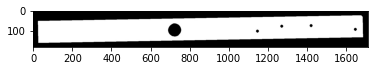

True

In [2]:
# 0：black 1:white

import os.path
import matplotlib.pyplot as plt
import cv2
import torch
from src.dataset.linemod_2d import read_scannet_gray
from src.utils.plotting import make_matching_figure
data_dir = "/home/gzr/Data/linemod_2d/DATA/steel"
image_id = "00000"
image_dir = os.path.join(data_dir,image_id)
image_path = os.path.join(image_dir,'matchedMask.jpg')


img_mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
contours_points = get_contours_points(img_mask)

img_mask ,bias = crop_image(img_mask, padding=20)


# print(img_mask.shape)
# img_mask = cv2.resize(img_mask, (400,200))
img_mask = cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB)
print(len(bias))
np.savetxt(os.path.join(image_dir,'bias.txt'),bias,fmt='%i')

plt.imshow(img_mask)
plt.show()
cv2.imwrite(os.path.join(image_dir,'template.jpg'),img_mask)




In [143]:
from src.utils.dataset import read_megadepth_gray, read_megadepth_depth,pad_bottom_right
import matplotlib.cm as cm
data_dir = "/home/gzr/Data/linemod_2d/DATA/steel"
image_id = "00003"
image_dir = os.path.join(data_dir,image_id)

mask_path = os.path.join(image_dir,'template.jpg')
image_path = os.path.join(image_dir,'localObjImg.jpg')

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img_size  = 512
image0, mask0, scale0 = read_megadepth_gray(
            mask_path, img_size, None, True, None)


image1, mask1, scale1 = read_megadepth_gray(
            image_path, img_size, None, True, None)

image0 = cv2.resize(mask,dsize=(0,0),fx=1/float(scale1[0]),fy=1/float(scale1[1]))
image0, mask = pad_bottom_right(image0, img_size, ret_mask=True)

print(image0.shape)
bias = np.loadtxt(os.path.join(image_dir,'bias.txt'))

mkpts0 = np.array([[310,25],[10,30]]) # x,y
mkpts1 = mkpts0 + [bias[0]/scale1[0],bias[1]/scale1[1]]
mconf = [0.2,1]
color = cm.jet(mconf)
print(scale1)
# fig = make_matching_figure(mask, image, mkpts0, mkpts1, color)
fig = make_matching_figure(image0.squeeze(), image1.squeeze(), mkpts0, mkpts1, color)
plt.savefig(os.path.join(image_dir,'a.jpg'), bbox_inches='tight', pad_inches=0,figsize=(1000,1000))
plt.close()
fig


AttributeError: 'NoneType' object has no attribute 'shape'

In [1]:
# batch process
import os.path
import matplotlib.pyplot as plt
import cv2
import torch
import numpy as np
from src.dataset.linemod_2d import read_scannet_gray
from src.utils.plotting import make_matching_figure
data_dir = "/home/gzr/Data/linemod_2d/DATA/steel_train"

def crop_image(image, padding=50):
    """
    crop the black block
    :param image:(H,W)
    :param padding:int
    :return:image:(H_,W_) bias [x,y]
    """
    assert (len(image.shape)==2)
    H, W = image.shape[0],image.shape[1]
    ind = list(np.nonzero(image))
    max_y,min_y = int(np.max(ind[0])),int(np.min(ind[0]))
    max_x,min_x = int(np.max(ind[1])),int(np.min(ind[1]))
    min_x = max(min_x-padding,0)
    min_y = max(min_y-padding,0)
    max_x = min((max_x+padding),W)
    max_y = min((max_y+padding),H)
    cropped = image[min_y:max_y, min_x:max_x]
    bias = np.array([min_x,min_y])
    return cropped,bias


def process_image(image_id):
    image_dir = os.path.join(data_dir,image_id)
    image_path = os.path.join(image_dir,'matchedMask.jpg')
    img_mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    img_mask ,bias = crop_image(img_mask, padding=20)
    img_mask = cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB)
    np.savetxt(os.path.join(image_dir,'bias.txt'),bias,fmt='%i')
    # plt.imshow(img_mask)
    # plt.show()
    cv2.imwrite(os.path.join(image_dir,'template.jpg'),img_mask)

for i in range(0,8166):
    image_id = f'{i:05d}'
    print(image_id,'\t')
    process_image(image_id)
# f=open("img_list.txt","w")
# for i in range(8166):
#
#     image_id = f'{i:05d}'
#     f.write(image_id+'\n')
# f.close()


00000 	


AttributeError: 'NoneType' object has no attribute 'shape'

In [3]:
for i in range(5,7):
    print(i)

5
6


In [7]:
image = cv2.imread('/home/gzr/Data/linemod_2d/DATA/steel_test/08156/matchedEdge.jpg',0)
print(image.shape)

(494, 2167)
